<a href="https://colab.research.google.com/github/pianonyy/UPLIFT_modeling/blob/master/Siamese_networks_uplift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import warnings
import numpy as np
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.validation import check_consistent_length
from sklearn.metrics import auc

from torch.autograd import Variable

In [2]:
def qini_curve(y_true, uplift, treatment): #think about names uplift score?

    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    desc_score_indices = np.argsort(uplift, kind="mergesort")[::-1]

    y_true = y_true[desc_score_indices]
    treatment = treatment[desc_score_indices]
    uplift = uplift[desc_score_indices]

    y_true_ctrl, y_true_trmnt = y_true.copy(), y_true.copy()

    y_true_ctrl[treatment == 1] = 0
    y_true_trmnt[treatment == 0] = 0

    distinct_value_indices = np.where(np.diff(uplift))[0]
    threshold_indices = np.r_[distinct_value_indices, uplift.size - 1]

    #print(threshold_indices.size)

    num_trmnt = stable_cumsum(treatment)[threshold_indices]
    y_trmnt = stable_cumsum(y_true_trmnt)[threshold_indices]

    num_all = threshold_indices + 1

    num_ctrl = num_all - num_trmnt
    y_ctrl = stable_cumsum(y_true_ctrl)[threshold_indices]

    curve_values = y_trmnt - y_ctrl * np.divide(num_trmnt, num_ctrl, out=np.zeros_like(num_trmnt), where=num_ctrl != 0)
    if num_all.size == 0 or curve_values[0] != 0 or num_all[0] != 0:
       
        num_all = np.r_[0, num_all]
        curve_values = np.r_[0, curve_values]

    return num_all, curve_values

def perfect_qini_curve(y_true, treatment):
  
    check_consistent_length(y_true, treatment)
    n_samples = len(y_true)

    y_true, treatment = np.array(y_true), np.array(treatment)

    
    
    x_perfect, y_perfect = qini_curve(
            y_true, y_true * treatment - y_true * (1 - treatment), treatment
    )
    

    return x_perfect, y_perfect

def qini_auc_score(y_true, uplift, treatment, negative_effect=True):
   
    check_consistent_length(y_true, uplift, treatment)

    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    treatment_count = np.count_nonzero(treatment == 1)


    x_model, y_model = qini_curve(y_true, uplift, treatment)
    x_perfect, y_perfect = perfect_qini_curve(y_true, treatment)
    x_baseline, y_baseline = np.array([0, x_perfect[-1]]), np.array([0, y_perfect[-1]])
    
    # print(np.size(treatment))
    #x_baseline, y_baseline = np.array([np.arange(0, np.size(treatment))]), np.array([0, y_perfect[-1]])
    

    auc_score_baseline = auc(x_baseline, y_baseline)
    auc_score_perfect = auc(x_perfect, y_perfect) - auc_score_baseline
    auc_score_model = auc(x_model, y_model) - auc_score_baseline

    return auc_score_model


In [3]:
import logging
from os.path import join as pjoin
from typing import Tuple

import pandas as pd
from sklearn.preprocessing import LabelEncoder

N_PURCHASES_ROWS = None
DATA_PATH = '/content/drive/MyDrive/' 
logger = logging.getLogger(__name__)


def load_clients() -> pd.DataFrame:
    return pd.read_csv(
        pjoin(DATA_PATH, 'clients.csv'),
        parse_dates=['first_issue_date', 'first_redeem_date'],
    )


def prepare_clients() -> Tuple[pd.DataFrame, LabelEncoder]:
    logger.info('Preparing clients...')
    clients = load_clients()
    client_encoder = LabelEncoder()
    clients['client_id'] = client_encoder.fit_transform(clients['client_id'])
    logger.info('Clients are ready')
    return clients, client_encoder


def load_products() -> pd.DataFrame:
    return pd.read_csv(pjoin(DATA_PATH, 'products.csv'))


def prepare_products() -> Tuple[pd.DataFrame, LabelEncoder]:
    logger.info('Preparing products...')
    products = load_products()
    product_encoder = LabelEncoder()
    products['product_id'] = product_encoder. \
        fit_transform(products['product_id'])

    products.fillna(-1, inplace=True)

    for col in [
        'level_1', 'level_2', 'level_3', 'level_4',
        'segment_id', 'brand_id', 'vendor_id',
    ]:
        products[col] = LabelEncoder().fit_transform(products[col].astype(str))
    logger.info('Products are ready')
    return products, product_encoder


def load_purchases() -> pd.DataFrame:
    logger.info('Loading purchases...')
    purchases = pd.read_csv(
        pjoin(DATA_PATH, 'purchases.csv'),
        nrows=N_PURCHASES_ROWS,
    )
    logger.info('Purchases are loaded')
    return purchases


def prepare_purchases(
        client_encoder: LabelEncoder,
        product_encoder: LabelEncoder,
) -> pd.DataFrame:
    logger.info('Preparing purchases...')
    purchases = load_purchases()

    logger.info('Handling n/a values...')
    purchases.dropna(
        subset=['client_id', 'product_id'],
        how='any',
        inplace=True,
    )
    purchases.fillna(-1, inplace=True)

    logger.info('Label encoding...')
    purchases['client_id'] = client_encoder.transform(purchases['client_id'])
    purchases['product_id'] = product_encoder.transform(purchases['product_id'])
    for col in ['transaction_id', 'store_id']:
        purchases[col] = LabelEncoder(). \
            fit_transform(purchases[col].astype(str))

    logger.info('Date and time conversion...')
    purchases['datetime'] = pd.to_datetime(
        purchases['transaction_datetime'],
        format='%Y-%m-%d %H:%M:%S',
    )
    purchases.drop(columns=['transaction_datetime'], inplace=True)

    logger.info('Purchases are ready')
    return purchases


def load_train() -> pd.DataFrame:
    return pd.read_csv(
        pjoin(DATA_PATH, 'uplift_train.csv'),
        index_col='client_id',
    )


def load_test() -> pd.DataFrame:
    return pd.read_csv(
        pjoin(DATA_PATH, 'uplift_test.csv'),
        index_col='client_id',
    )


In [4]:
!unzip /content/drive/MyDrive/features.zip

Archive:  /content/drive/MyDrive/features.zip
replace features.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
!pip install pickle5

In [6]:
import pickle5
RANDOM_STATE = 12
from sklearn.model_selection import train_test_split

train = load_train()
indices_train = train.index
with open('features.pkl', 'rb') as f:
        features: pd.DataFrame = pickle5.load(f)

features.set_index('client_id', inplace=True)
X_train = features.loc[indices_train, :]



treatment_train = train.loc[indices_train, 'treatment_flg'].values
y_train = train.loc[indices_train, 'target'].values

X_train['treatment'] = treatment_train
X_train['target'] = y_train

X_train.loc[(X_train['target'] == 1) & (X_train['treatment'] == 1),'Z_trans'] = 2 # 2
X_train.loc[(X_train['target'] == 1) & (X_train['treatment'] == 0),'Z_trans'] = 1 # 0
X_train.loc[X_train['Z_trans'].isnull(), 'Z_trans'] = 0  #-2

# Z_trans = X_train['Z_trans']


indices_learn, indices_valid = train_test_split(
        X_train.index,
        test_size=0.3,
        random_state = RANDOM_STATE,
)

all = X_train.copy()
X_train =all.loc[indices_learn,]
X_test = all.loc[indices_valid,]


treatment_train = X_train['treatment']
y_train = X_train['target']
Z_trans_train = X_train['Z_trans']

treatment_test = X_test['treatment']
y_test = X_test['target']
Z_trans_test = X_test['Z_trans']


X_train=X_train.drop('Z_trans',axis = 1)
X_train=X_train.drop('target',axis = 1)
X_train=X_train.drop('treatment',axis = 1)

X_test=X_test.drop('Z_trans',axis = 1)
X_test=X_test.drop('target',axis = 1)
X_test=X_test.drop('treatment',axis = 1)


# print(treatment_test)
# print(treatment_train)

print("propensity score in train:", treatment_train[treatment_train == 1].shape[0] / treatment_train.shape[0])
print("propensity score in test:", treatment_test[treatment_test == 1].shape[0] / treatment_test.shape[0])

print(X_train)
print(X_test)

print(Z_trans_train[Z_trans_train == 0])

propensity score in train: 0.49853596526309774
propensity score in test: 0.5027911549549249
            gender_M  gender_F  ...  brand_id_nunique  vendor_id_nunique
client_id                       ...                                     
5803624422         0         0  ...                26                 20
20b7b05f7d         1         0  ...                54                 42
0c10e0113f         0         0  ...                41                 31
1761677f2d         0         0  ...                51                 47
aa188a0008         1         0  ...                24                 20
...              ...       ...  ...               ...                ...
4ef8dd16ad         0         1  ...               105                 86
a54f58238b         0         0  ...                33                 29
2e7eeaca71         0         0  ...                60                 54
332b911361         0         1  ...                24                 22
c13eba9d88         0         0  

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

Z_train_dummies = pd.get_dummies(Z_trans_train)
Z_test_dummies = pd.get_dummies(Z_trans_test)

print(Z_train_dummies)
print(Z_test_dummies)

            0.0  1.0  2.0
client_id                
5803624422    1    0    0
20b7b05f7d    0    1    0
0c10e0113f    1    0    0
1761677f2d    0    0    1
aa188a0008    0    1    0
...         ...  ...  ...
4ef8dd16ad    0    0    1
a54f58238b    0    0    1
2e7eeaca71    1    0    0
332b911361    0    0    1
c13eba9d88    1    0    0

[140024 rows x 3 columns]
            0.0  1.0  2.0
client_id                
353f2648f3    1    0    0
f0d6002166    1    0    0
af4f3039fe    0    0    1
34b4ce6c2a    0    0    1
7046ea76d3    0    0    1
...         ...  ...  ...
d5c9592f5f    0    1    0
555d2436d3    0    1    0
bc21e85e6e    0    1    0
aa4d24e82f    1    0    0
ad18c83a2e    0    0    1

[60011 rows x 3 columns]


In [8]:
from sklearn.preprocessing import StandardScaler 
import numpy as np


scaler = StandardScaler(with_std = False, with_mean = False)

X_train_0 = X_train.copy()
# X_train_0['treatment'] = 0

X_train_1 = X_train.copy()
# X_train_1['treatment'] = 1

X_train_1 = X_train_1.astype('float32')
X_train_1 = X_train_1.replace([np.inf, -np.inf], np.nan).fillna(0)
X_train_1 = scaler.fit_transform(X_train_1)



X_train_0 = X_train_0.astype('float32')
X_train_0 = X_train_0.replace([np.inf, -np.inf], np.nan).fillna(0)
X_train_0 = scaler.fit_transform(X_train_0)


X_test_0 = X_test.copy()
# X_test_0['treatment'] = 0

X_test_1 = X_test.copy()
# X_test_1['treatment'] = 1

X_test_1 = X_test_1.astype('float32')
X_test_1 = X_test_1.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_1 = scaler.fit_transform(X_test_1)

X_test_0 = X_test_0.astype('float32')
X_test_0 = X_test_0.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_0 = scaler.fit_transform(X_test_0)



X_train_0 = np.c_[ X_train_0, np.zeros(X_train_0.shape[0]) ]
X_train_1 = np.c_[ X_train_1, np.ones(X_train_1.shape[0]) ]

X_test_0 = np.c_[ X_test_0, np.zeros(X_test_0.shape[0]) ]
X_test_1 = np.c_[ X_test_1, np.ones(X_test_1.shape[0]) ] 

print(X_train_0, "size = ", X_train_0.shape)
print(X_train_1, "size = ", X_train_1.shape)

print(X_test_0, "size = ", X_test_0.shape)
print(X_test_1, "size = ", X_test_1.shape)

[[ 0.  0.  1. ... 26. 20.  0.]
 [ 1.  0.  0. ... 54. 42.  0.]
 [ 0.  0.  1. ... 41. 31.  0.]
 ...
 [ 0.  0.  1. ... 60. 54.  0.]
 [ 0.  1.  0. ... 24. 22.  0.]
 [ 0.  0.  1. ... 62. 61.  0.]] size =  (140024, 334)
[[ 0.  0.  1. ... 26. 20.  1.]
 [ 1.  0.  0. ... 54. 42.  1.]
 [ 0.  0.  1. ... 41. 31.  1.]
 ...
 [ 0.  0.  1. ... 60. 54.  1.]
 [ 0.  1.  0. ... 24. 22.  1.]
 [ 0.  0.  1. ... 62. 61.  1.]] size =  (140024, 334)
[[ 0.  0.  1. ... 11.  9.  0.]
 [ 0.  1.  0. ... 22. 19.  0.]
 [ 0.  0.  1. ...  7.  8.  0.]
 ...
 [ 0.  1.  0. ... 51. 43.  0.]
 [ 0.  0.  1. ... 47. 39.  0.]
 [ 0.  0.  1. ... 36. 29.  0.]] size =  (60011, 334)
[[ 0.  0.  1. ... 11.  9.  1.]
 [ 0.  1.  0. ... 22. 19.  1.]
 [ 0.  0.  1. ...  7.  8.  1.]
 ...
 [ 0.  1.  0. ... 51. 43.  1.]
 [ 0.  0.  1. ... 47. 39.  1.]
 [ 0.  0.  1. ... 36. 29.  1.]] size =  (60011, 334)


In [9]:
class trainData(Dataset):
    
    def __init__(self, X_data_0,X_data_1,Z_trans,treatment, y_data):
        self.X_data_0 = X_data_0
        self.X_data_1 = X_data_1
        self.Z_trans = Z_trans
        self.treatment = treatment
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data_0[index], self.X_data_1[index],self.Z_trans[index], self.treatment[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data_0)


train_data = trainData(torch.FloatTensor(X_train_0),torch.FloatTensor(X_train_1),torch.FloatTensor(Z_trans_train),torch.FloatTensor(treatment_train), 
                       torch.FloatTensor(y_train))
## test data    

class testData(Dataset):
    
    def __init__(self, X_data_0,X_data_1,Z_trans,treatment,y_data):
        self.X_data_0 = X_data_0
        self.X_data_1 = X_data_1
        self.Z_trans = Z_trans
        self.treatment = treatment
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data_0[index], self.X_data_1[index],self.Z_trans[index], self.treatment[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data_0)
    

test_data = testData(torch.FloatTensor(X_test_0),torch.FloatTensor(X_test_1), torch.FloatTensor(Z_trans_test),torch.FloatTensor(treatment_test), 
                       torch.FloatTensor(y_test))

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import pylab

  
from sklearn.utils.validation import check_consistent_length



def plot_qini_curve(y_reactions, uplift_score, treatment, random=True, perfect=True):
    """Plot Qini curves from predictions."""
   
    check_consistent_length(y_reactions, uplift_score, treatment)
    y_reactions, uplift_score, treatment = np.array(y_reactions), np.array(uplift_score), np.array(treatment)

   

    x_actual, y_actual = qini_curve(y_reactions, uplift_score, treatment)

    pylab.plot(x_actual, y_actual, label='Our model', color='green')
    if random:
        x_baseline, y_baseline = x_actual, x_actual * y_actual[-1] / len(y_reactions)
        pylab.plot(x_baseline, y_baseline, label='Random model', color='black')
        

    if perfect:
        x_perfect, y_perfect = perfect_qini_curve(y_reactions, treatment)
        # print("1 point", x_perfect[1], y_perfect[1])
        # print("2 point", x_perfect[2], y_perfect[2])
        # print("3 point", x_perfect[3], y_perfect[3])
        pylab.plot(x_perfect, y_perfect, label='Perfect model', color='Red')
        
    #pylab.fill_between(x_perfect, y_baseline, y_perfect, color="blue")
    pylab.grid(True)
    pylab.xlabel('Treat num')
    pylab.ylabel('Uplift reactions')
    pylab.title('Qini curve')
    pylab.legend(loc='lower right')
    return pylab




cross entropy with Z_dummies

.......................... epoch = 0 ..........................


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Z_train tensor([0, 0, 2,  ..., 2, 2, 2])
uplift_pred tensor([[ 3.5501e-04, -3.5504e-04,  0.0000e+00],
        [ 4.5896e-06, -4.6007e-06,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        ...,
        [ 2.9667e-06, -2.9802e-06, -1.0733e-41],
        [ 2.9206e-06, -2.8796e-06, -6.4862e-30],
        [-2.1059e-04,  2.1058e-04,  0.0000e+00]], grad_fn=<SubBackward0>)
Z_train tensor([2, 0, 2,  ..., 2, 2, 0])
uplift_pred tensor([[ 1.0759e-25,  0.0000e+00, -4.2308e-41],
        [ 1.5641e-27,  0.0000e+00,  0.0000e+00],
        [ 1.3574e-14,  0.0000e+00, -2.6583e-34],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]], grad_fn=<SubBackward0>)
Z_train tensor([2, 0, 2,  ..., 1, 0, 0])
uplift_pred tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 4.0818e-24,  0.0000e+00, -5.1593e-32],
        [ 2.7031e-34,  0.0000e+00,  0.0000e+00],
        ...,
        [ 9.1222e

Text(0, 0.5, 'loss sum')

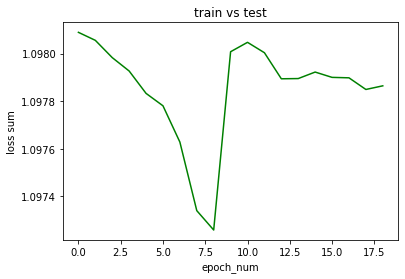

In [10]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 35006   # Number of samples in each batch
batch_size_test=7 #7
epoch_num = 19  # Number of epochs to train the network  to do try more epochs
lr = 0.001        # Learning rate





class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(334, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 3)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        m = nn.Softmax()
        return m(x)
        

model = Model()
alpha = 1.0

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# model.to(device)
# print(model)


# #convert to torch structure
# X_test_1_tensor = torch.FloatTensor(X_test_1) 
# X_test_0_tensor = torch.FloatTensor(X_test_0)


# #convert to torch structure
# treatment_test = treatment_test.to_numpy()
# treatment_test = torch.from_numpy(treatment_test).int()
# treatment_test = Variable(treatment_test)


# #convert to torch structure
# y_test = y_test.to_numpy()
# y_test = torch.from_numpy(y_test).float()
# y_test  = Variable(y_test)


# #convert to torch structure
# Z_trans_test = Z_trans_test.to_numpy()
# Z_trans_test = torch.from_numpy(Z_trans_test).float()
# Z_trans_test = Variable(Z_trans_test)


#init loaders
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size_test, shuffle=True)




# define the loss (criterion) and create an optimizer
optimizer = optim.Adam(model.parameters())

# define lists of losses to store
all_losses  = []
test_losses = []
min_losses = []


model.train()
# epochs loop
for ep in range(epoch_num):  
    print(".......................... epoch =",ep,"..........................")
    batch_loss = []
    # batches loop
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in train_loader:
       
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

        #convert to torch structure
        treatment_batch = treatment_batch
       

        # mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        # mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
     


       
        #implements mu = T * mu_1 + (1-T) * mu_0
        # uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        

        
       

       
        
        
        #declare losses
        loss_cross = nn.CrossEntropyLoss()
      

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 
        
        # Z_trans_train = torch.Tensor(Z_batch) 
        # Z_dummies = torch.nn.functional.one_hot(Z_trans_train.to(torch.int64), num_classes = 3)

        Z_trans_train = Z_batch.to(torch.int64)
        print("Z_train",Z_trans_train)

        pred_uplift = mu_1_target_class - mu_0_target_class
        print("uplift_pred", pred_uplift)

       
        

        sum_of_losses = torch.mean(  loss_cross(mu_1_target_class-mu_0_target_class,Z_trans_train) )
        # print(loss_contrastive)
        batch_loss.append(sum_of_losses)
        # print("train AUQC:", qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        # Backward pass and updates
        sum_of_losses.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        # i += batch_size
        #end for !!!!!!!!!!!!!!!!!!!

    # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
    # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss) ) 

    # # #work with test dataset
    # print('work with test dataset')
    # batch_loss = []
    # for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in test_loader:
        
       
        
    #     batch_1_feat = X_batch_1
    #     batch_0_feat = X_batch_0
        
    #     batch_label = y_batch
    #     batch_Z_trans = Z_batch

    #     optimizer.zero_grad()
    #     # Forward pass (predict)
    #     mu_1_target_class = model(batch_1_feat)
    #     mu_0_target_class = model(batch_0_feat)

       
       

    #     # mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
    #     # mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
    #     # print("mu_0", mu_0_target_class)
    #     # print("mu_1", mu_1_target_class)

    #     ones = np.ones(shape = batch_size_test)
    #     ones = torch.from_numpy(ones).float()
        
     
    #     #implements mu = T * mu_1 + (1-T) * mu_0
    #     uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

    #     #declare losses
    #     loss_cross = nn.BCELoss(reduction = 'mean')
    #     loss_MSE = nn.MSELoss()

    #     #implements uplift_predicted = mu_1 - mu_0
    #     uplift_pred = mu_1_target_class - mu_0_target_class   

    #     sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
       
    #     batch_loss.append(sum_of_losses)
        

        
    #     # print(batch_n, loss_contrastive)


    #     # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
    #     # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        
        
        #end for
    # batch_loss  = list(batch_loss)
    # test_losses.append( sum(batch_loss) / len(batch_loss) ) 
    

    
   

import matplotlib.pyplot as plt

plt.plot(all_losses, color='green',label='train')
plt.title('train vs test')
plt.xlabel('epoch_num')
plt.ylabel('loss sum')



# plt.plot(test_losses, color='blue',label='test')
# plt.legend()


# plt.show()





In [23]:
model.eval()
pred0=model(torch.FloatTensor(X_train_0))
pred1=model(torch.FloatTensor(X_train_1))

# print(treatment_train[6])
# print(y_train[6])

pred_uplift = (pred1-pred0).cpu().detach().numpy() 




print("max", np.max(pred_uplift))
print("min", np.min(pred_uplift))


print(pred_uplift[200:250])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


max 0.08126339
min -0.08126342
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 2.2411346e-05 -2.2347012e-05 -2.0004250e-22]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.1231806e-41  0.0000000e+00]
 [ 2.9485715e-34  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.4012985e-45  0.0000000e+00]
 [ 0.0000000e+00 -5.7481197e-22 -3.9572669e-42]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 7.7835339e-06 -7.7486038e-06  2.6556181e-21]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 2.1295699e-18  0.0000000e+00  8.4368114e-14]
 [ 0.0000000e+00  0.0000000e+00  2.8755774e-37]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.2785059e-27 -8.1517483e-30]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 1.4012985e-45  0.0000000e+00  0.0000000e+00]
 [ 0.0000

neural network with dataloader

.......................... epoch = 0 ..........................
-7275.33287389949
work with test dataset
.......................... epoch = 1 ..........................
-8342.911316879094
work with test dataset
.......................... epoch = 2 ..........................
-611123.7049457598
work with test dataset
.......................... epoch = 3 ..........................
-783300.762356434
work with test dataset
.......................... epoch = 4 ..........................
-1313361.2020577732
work with test dataset
.......................... epoch = 5 ..........................
-989843.8938561417
work with test dataset
.......................... epoch = 6 ..........................
-1170888.0309360344
work with test dataset
.......................... epoch = 7 ..........................
-740651.3018418681
work with test dataset
.......................... epoch = 8 ..........................
285600.76617391594
work with test dataset


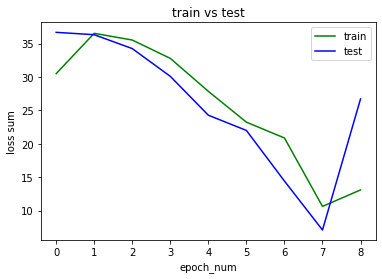

In [89]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 35006   # Number of samples in each batch to do(/9)
batch_size_test=7 #7
epoch_num = 9  # Number of epochs to train the network
lr = 0.001        # Learning rate





class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(334, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        m = nn.Sigmoid()
        return m(x)
        

model = Model()
alpha = 1.0

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# model.to(device)
# print(model)


# #convert to torch structure
# X_test_1_tensor = torch.FloatTensor(X_test_1) 
# X_test_0_tensor = torch.FloatTensor(X_test_0)


# #convert to torch structure
# treatment_test = treatment_test.to_numpy()
# treatment_test = torch.from_numpy(treatment_test).int()
# treatment_test = Variable(treatment_test)


# #convert to torch structure
# y_test = y_test.to_numpy()
# y_test = torch.from_numpy(y_test).float()
# y_test  = Variable(y_test)


# #convert to torch structure
# Z_trans_test = Z_trans_test.to_numpy()
# Z_trans_test = torch.from_numpy(Z_trans_test).float()
# Z_trans_test = Variable(Z_trans_test)


#init loaders
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size_test, shuffle=True)




# define the loss (criterion) and create an optimizer
optimizer = optim.Adam(model.parameters())

# define lists of losses to store
all_losses  = []
test_losses = []
min_losses = []


model.train()
# epochs loop
for ep in range(epoch_num):  
    print(".......................... epoch =",ep,"..........................")
    batch_loss = []
    # batches loop
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in train_loader:
       
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

        #convert to torch structure
        treatment_batch = treatment_batch
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        

       
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        

        
       

       
        
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 
        
        
        # print("uplift_pred", uplift_pred)

        

        

        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
        # print(loss_contrastive)
        batch_loss.append(sum_of_losses)
        # print("train AUQC:", qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        # Backward pass and updates
        sum_of_losses.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        # i += batch_size
        #end for !!!!!!!!!!!!!!!!!!!

    # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
    print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss) ) 

    # #work with test dataset
    print('work with test dataset')
    batch_loss = []
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in test_loader:
        
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

       
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size_test)
        ones = torch.from_numpy(ones).float()
        
     
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class   

        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
       
        batch_loss.append(sum_of_losses)
        

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        
        
        #end for
    batch_loss  = list(batch_loss)
    test_losses.append( sum(batch_loss) / len(batch_loss) ) 
    

    
   

import matplotlib.pyplot as plt

plt.plot(all_losses, color='green',label='train')
plt.title('train vs test')
plt.xlabel('epoch_num')
plt.ylabel('loss sum')



plt.plot(test_losses, color='blue',label='test')
plt.legend()


plt.show()





In [90]:
X_train_1 = torch.FloatTensor(X_train_1)
X_train_0 = torch.FloatTensor(X_train_0)



model.eval()

mu_1 = model(X_train_1)
mu_0 = model(X_train_0)

pred = mu_1-mu_0
print(qini_auc_score(y_train, pred.detach().numpy(), treatment_train))

print(pred)
print(torch.min(pred))

-163578094.97352487
tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], grad_fn=<SubBackward0>)
tensor(-0.0015, grad_fn=<MinBackward1>)


proposing network with sigmoid





.......................... epoch = 0 ..........................
575714.2897998542
.......................... epoch = 1 ..........................
687202.8238649331
.......................... epoch = 2 ..........................
821170.2098770794
.......................... epoch = 3 ..........................
-594238.355457807
.......................... epoch = 4 ..........................
191489.89595435932
.......................... epoch = 5 ..........................
1920812.4279926438
.......................... epoch = 6 ..........................
1839840.097914366
.......................... epoch = 7 ..........................
778815.5585964136
.......................... epoch = 8 ..........................
1455925.2160117794
.......................... epoch = 9 ..........................
2076258.8061467446
.......................... epoch = 10 ..........................
2738230.5120166615
.......................... epoch = 11 ..........................
1853678.505014794
.........

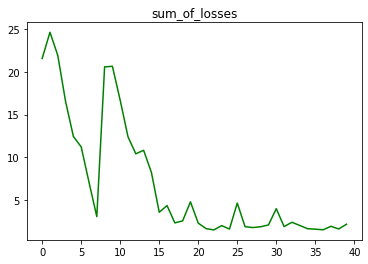

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 35006   # Number of samples in each batch
epoch_num = 40   # Number of epochs to train the network
lr = 0.0001        # Learning rate





class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(334, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        m = nn.Sigmoid()
        return m(x)
        

model = Model()
alpha = 0.8

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# model.to(device)
# print(model)


# #convert to torch structure
# X_test_1_tensor = torch.FloatTensor(X_test_1) 
# X_test_0_tensor = torch.FloatTensor(X_test_0)


# #convert to torch structure
# treatment_test = treatment_test.to_numpy()
# treatment_test = torch.from_numpy(treatment_test).int()
# treatment_test = Variable(treatment_test)


# #convert to torch structure
# y_test = y_test.to_numpy()
# y_test = torch.from_numpy(y_test).float()
# y_test  = Variable(y_test)


# #convert to torch structure
# Z_trans_test = Z_trans_test.to_numpy()
# Z_trans_test = torch.from_numpy(Z_trans_test).float()
# Z_trans_test = Variable(Z_trans_test)


#init loaders
# train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset=test_data, batch_size=1)


# calculate the number of batches per epoch
batch_per_ep = X_train.shape[0] // batch_size

# define the loss (criterion) and create an optimizer
optimizer = optim.Adam(model.parameters())

# define lists of losses to store
all_losses  = []
test_losses = []
min_losses = []


model.train()
# epochs loop
for ep in range(epoch_num):  
    print(".......................... epoch =",ep,"..........................")
    i = 0
    # batches loop
    for batch_n in range(batch_per_ep):  
        batch_loss = []
       
        
        batch_1_feat = torch.FloatTensor(X_train_1[i:i+batch_size])
        batch_0_feat = torch.FloatTensor(X_train_0[i:i+batch_size])
        
        batch_label = y_train[i:i+batch_size]
        batch_Z_trans = Z_trans_train[i:i+batch_size]

        optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

        #convert to torch structure
        treatment_batch = treatment_train[i:i+batch_size]
        treatment_batch = treatment_batch.to_numpy()
        treatment_batch = torch.from_numpy(treatment_batch).int()
        treatment_batch = Variable(treatment_batch)

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        

       
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        

        
        #convert to torch structure
        batch_label = batch_label.to_numpy()
        batch_label = torch.from_numpy(batch_label).float()
        batch_label = Variable(batch_label)

       
        #convert to torch structure
        batch_Z_trans = batch_Z_trans.to_numpy()
        batch_Z_trans = torch.from_numpy(batch_Z_trans).float()
        batch_Z_trans = Variable(batch_Z_trans)
        batch_Z_trans = torch.reshape(batch_Z_trans, shape = (-1,))
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 
        
        
        # print("uplift_pred", uplift_pred)

        

        

        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
        # print(loss_contrastive)
        batch_loss.append(sum_of_losses)
        # print("train AUQC:", qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        # Backward pass and updates
        sum_of_losses.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        i += batch_size
        #end for !!!!!!!!!!!!!!!!!!!

    # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
    print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss) ) 

    # #work with test dataset

    # mu_1 = model(X_test_1_tensor)
    # mu_0 = model(X_test_0_tensor)

    # mu_1_target_class = mu_1
    # mu_0_target_class = mu_0

    # ones = np.ones(shape = X_test_1.shape[0])
    # ones = torch.from_numpy(ones).float()

    # #implements mu = T * mu_1 + (1-T) * mu_0
    # uplift_pred_Y = treatment_test * mu_1_target_class + (ones - treatment_test) * mu_0_target_class 

    # mu_0_target_class = torch.reshape(mu_0_target_class, (-1,))
    # mu_1_target_class = torch.reshape(mu_1_target_class, (-1,))
    

    
   
    
    # #declare losses
    # loss_cross = nn.BCELoss(reduction = 'mean')
    # loss_MSE = nn.MSELoss()

    # #implements uplift_predicted = mu_1 - mu_0
    # uplift_pred = mu_1_target_class - mu_0_target_class 

    # sum_of_losses =torch.mean(  (1-alpha) * loss_MSE(Z_trans_test, uplift_pred) + alpha * loss_cross( uplift_pred_Y, y_test) )
    # test_losses.append(sum_of_losses)

import matplotlib.pyplot as plt

plt.plot(all_losses, color='green')
plt.title('sum_of_losses')
plt.show()

# plt.plot(test_losses, color='blue')
# plt.title('sum_of_losses')
# plt.show()





In [ ]:
X_train_1 = torch.FloatTensor(X_train_1)
X_train_0 = torch.FloatTensor(X_train_0)



model.eval()

mu_1 = model(X_train_1)
mu_0 = model(X_train_0)

pred = mu_1-mu_0
print(qini_auc_score(y_train, pred.detach().numpy(), treatment_train))

print(pred)
print(torch.max(pred))

-163578094.97352487
tensor([[1.0186e-03],
        [6.4969e-06],
        [4.1914e-04],
        ...,
        [1.0187e-03],
        [9.6339e-04],
        [1.5497e-06]], grad_fn=<SubBackward0>)
tensor(0.0022, grad_fn=<MaxBackward1>)


example of siamese network!!!!
 

In [ ]:
from __future__ import print_function
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 55   # Number of samples in each batch
epoch_num = 12      # Number of epochs to train the network
lr = 0.001        # Learning rate
import torch.nn.functional as F




class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(334, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.exp(F.log_softmax(x,dim=1))    # F.log_softmax = log( exp(x_i) / exp(x).sum() )
        #return x



model = Model()
alpha = 0.9


# calculate the number of batches per epoch
batch_per_ep = X_train.shape[0] // batch_size

# define the loss (criterion) and create an optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)

# X_test_1_tensor = torch.FloatTensor(X_test_1)
# X_test_0_tensor = torch.FloatTensor(X_test_0)

# treatment_test = treatment_test.to_numpy()
# treatment_test = torch.from_numpy(treatment_test).int()
# treatment_test = Variable(treatment_test)

# y_test = y_test.to_numpy()
# y_test = torch.from_numpy(y_test ).float()
# y_test  = Variable(y_test )


# #convert to torch structure
# Z_trans_test = Z_trans_test.to_numpy()
# Z_trans_test = torch.from_numpy(Z_trans_test).float()
# Z_trans_test = Variable(Z_trans_test)

# Z_trans_test = torch.reshape(Z_trans_test, (X_test_1.shape[0],1))

all_losses  = []
test_losses = []
min_losses = []

for ep in range(epoch_num):  # epochs loop
    print("..........................epoch =",ep,"..........................")
    i = 0
    for batch_n in range(batch_per_ep):  # batches loop
        batch_loss = []
       
        
        batch_1_feat = torch.FloatTensor(X_train_1[i:i+batch_size])
        batch_0_feat = torch.FloatTensor(X_train_0[i:i+batch_size])
        
        batch_label = y_train[i:i+batch_size]
        batch_Z_trans = Z_trans_train[i:i+batch_size]

        # Reset gradients
        # optimizer.zero_grad()

        # Forward pass
        mu_1 = model(batch_1_feat)
        mu_0 = model(batch_0_feat)

        mu_1_target_class = mu_1[:,1]
        mu_0_target_class = mu_0[:,1]

        treatment_batch = treatment_train[i:i+batch_size]
        treatment_batch = treatment_batch.to_numpy()
        treatment_batch = torch.from_numpy(treatment_batch).int()
        treatment_batch = Variable(treatment_batch)


        
        
        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 


        mu_0_target_class = torch.reshape(mu_0_target_class, (batch_size,1))
        mu_1_target_class = torch.reshape(mu_1_target_class, (batch_size,1))
        #convert to torch structure
        batch_label = batch_label.to_numpy()
        batch_label = torch.from_numpy(batch_label).float()
        batch_label = Variable(batch_label)

       
        #convert to torch structure
        batch_Z_trans = batch_Z_trans.to_numpy()
        batch_Z_trans = torch.from_numpy(batch_Z_trans).float()
        batch_Z_trans = Variable(batch_Z_trans)

        batch_Z_trans = torch.reshape(batch_Z_trans, (batch_size,1))
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'sum')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 
        

        
        loss_contrastive = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
        
        batch_loss.append(loss_contrastive)
        

        
        # print(batch_n, loss_contrastive)


        optimizer.zero_grad()
        # Backward pass and updates
        loss_contrastive.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        i += batch_size
        #end for!!!!!!!!!!!!!!!!!!!

    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss)) 
    #work with test dataset

    # mu_1 = model(X_test_1_tensor)
    # mu_0 = model(X_test_0_tensor)

    # mu_1_target_class = mu_1[:,1]
    # mu_0_target_class = mu_0[:,1]

    # ones = np.ones(shape = X_test_1.shape[0])
    # ones = torch.from_numpy(ones).float()

    # #implements mu = T * mu_1 + (1-T) * mu_0
    # uplift_pred_Y = treatment_test * mu_1_target_class + (ones - treatment_test) * mu_0_target_class 

    # mu_0_target_class = torch.reshape(mu_0_target_class, (X_test_1.shape[0],1))
    # mu_1_target_class = torch.reshape(mu_1_target_class, (X_test_1.shape[0],1))
    

    
   
    
    # #declare losses
    # loss_cross = nn.BCELoss(reduction = 'sum')
    # loss_MSE = nn.MSELoss()

    # #implements uplift_predicted = mu_1 - mu_0
    # uplift_pred = mu_1_target_class - mu_0_target_class 

    # loss_contrastive =torch.mean(  (1-alpha) * loss_MSE(Z_trans_test, uplift_pred) + alpha * loss_cross( uplift_pred_Y, y_test))
    # test_losses.append(loss_contrastive)
    
    # print(qini_auc_score(y_test.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_test.cpu().detach().numpy() ))

import matplotlib.pyplot as plt
plt.plot(all_losses,color='blue')
# plt.plot(test_losses, color='green')
plt.title('Contrastive Loss')
plt.show()

plt.plot(all_losses,color='blue')
plt.show()

..........................epoch = 0 ..........................
..........................epoch = 1 ..........................


RuntimeError: ignored

In [ ]:
from __future__ import print_function
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 55   # Number of samples in each batch
epoch_num = 20      # Number of epochs to train the network
lr = 0.001        # Learning rate
import torch.nn.functional as F




class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(334, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.exp(F.log_softmax(x,dim=1))
        #return x



model = Model()
alpha = 0.8


# calculate the number of batches per epoch
batch_per_ep = X_train.shape[0] // batch_size

# define the loss (criterion) and create an optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)







Z_trans_test = torch.reshape(Z_trans_test, (X_test_1.shape[0],1))
all_losses  = []
min_losses =[]
for ep in range(epoch_num):  # epochs loop
    print("..........................epoch =",ep,"..........................")
    i = 0
    for batch_n in range(batch_per_ep):  # batches loop
        batch_loss = []
       
        
        batch_1_feat = torch.FloatTensor(X_train_1[i:i+batch_size])
        batch_0_feat = torch.FloatTensor(X_train_0[i:i+batch_size])
        
        batch_label = y_train[i:i+batch_size]
        batch_Z_trans = Z_trans[i:i+batch_size]

        # Reset gradients
        # optimizer.zero_grad()

        # Forward pass
        mu_1 = model(batch_1_feat)
        mu_0 = model(batch_0_feat)

        mu_1_target_class = mu_1[:,1]
        mu_0_target_class = mu_0[:,1]

        treatment_batch = treatment_train[i:i+batch_size]
        treatment_batch = torch.from_numpy(treatment_batch).int()
        treatment_batch = Variable(treatment_batch)


        
        
        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 


        mu_0_target_class = torch.reshape(mu_0_target_class, (batch_size,1))
        mu_1_target_class = torch.reshape(mu_1_target_class, (batch_size,1))
        #convert to torch structure
        batch_label = torch.from_numpy(batch_label).float()
        batch_label = Variable(batch_label)

       
        #convert to torch structure
        batch_Z_trans = batch_Z_trans.to_numpy()
        batch_Z_trans = torch.from_numpy(batch_Z_trans).float()
        batch_Z_trans = Variable(batch_Z_trans)

        batch_Z_trans = torch.reshape(batch_Z_trans, (batch_size,1))
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'sum')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 

        loss_contrastive =torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))

        batch_loss.append(loss_contrastive)
        
        # print(batch_n, loss_contrastive)


        optimizer.zero_grad()
        # Backward pass and updates
        loss_contrastive.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        i += batch_size
    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss)) 

import matplotlib.pyplot as plt
plt.plot(all_losses)
plt.title('Contrastive Loss')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(all_losses[:210000])
plt.title('Contrastive Loss')
plt.show()